## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load Training Images

In [11]:
import glob
import os
import sys

def get_img_path_in_folder(path_folder):
    full_path = path_folder + '/**/*.png'
    img_path_list = []

    for filename in glob.iglob(full_path, recursive=True):
        img_path_list.append(filename)

    return img_path_list

data_folder = './data'
vehicles_folder = data_folder + '/vehicles'
non_vehicles_folder = data_folder + '/non-vehicles'

print(vehicles_folder)
print(non_vehicles_folder)

vehicle_img_path = get_img_path_in_folder(vehicles_folder)
non_vehicle_img_path = get_img_path_in_folder(non_vehicles_folder)
print(len(vehicle_img_path))
print(len(non_vehicle_img_path))

./data/vehicles
./data/non-vehicles
8792
8968


## Extract Features

In [86]:
from skimage.feature import hog
import numpy as np
import cv2

class Feature_extractor():
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.a = 10
        pass
    
    def extract(self, img):
        
        color_space = self.color_space
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat
        hog_feat = self.hog_feat
        
        #1) Define an empty list to receive features
        img_features = []
        
        #2) Apply color conversion if other than 'RGB'
        feature_image = self.transform_color(img, color_space)
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        
        
        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def transform_color(self, img, color_space='RGB'):
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        return feature_image
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 1)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    def aux(self):
            print(self.a)

In [87]:
import numpy as np


def images_load_subset(images_path, subset):
    img_len = len(images_path)
    subset = np.clip(subset, 0, 1)
    new_len = img_len*subset
    new_len = int(round(new_len))
    return images_path[:new_len]

new_vehicle_images_path = images_load_subset(vehicle_img_path, 0.001)
new_non_vehicle_images_path = images_load_subset(non_vehicle_img_path, 0.001)

print(len(new_vehicle_images_path))
print(len(new_non_vehicle_images_path))



9
9


6696
[[  6.78116531e+01]
 [ -6.41084099e+00]
 [  2.51234150e+00]
 ..., 
 [  2.57410578e-02]
 [  5.92119957e-03]
 [  2.62275014e-02]]
16.12 Seconds to extract HOG features...


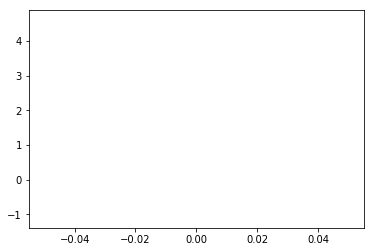

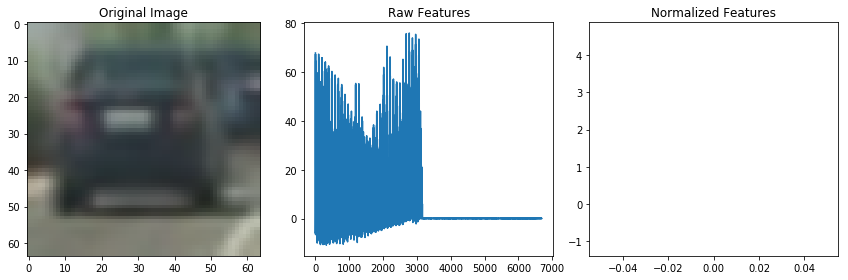

In [88]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler

%matplotlib inline

test_image = mpimg.imread(vehicle_img_path[0])
#print(test_image)

colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


extractor = Feature_extractor(color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t=time.time()
car_features = extractor.extract(test_image)

a = len(car_features)
print(a)
#X = np.vstack((car_features)).astype(np.float64)
#X_scaler = StandardScaler().fit(X)
#r = X_scaler.transform(np.array(car_features).reshape(1, -1))
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)
#print(X)
#plt.plot(r)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(car_features)
plt.title('Raw Features')
#plt.subplot(133)
#plt.plot(r)
#plt.title('Normalized Features')
fig.tight_layout()

## HOG